In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay 
from scipy.io import loadmat

In [2]:
matrix_GO=np.load('matrix_3000-3600.npy')
bin_size=10
n_bins=matrix_GO.shape[0]//bin_size
matrix_GO=matrix_GO[:n_bins*bin_size,:,:]
matrix_GO=matrix_GO.reshape(n_bins,bin_size,matrix_GO.shape[1],matrix_GO.shape[2])
matrix_GO=matrix_GO.sum(axis=1)
matrix_GO=matrix_GO.transpose(1,2,0)
print(matrix_GO.shape)
print(matrix_GO)

(795, 166, 60)
[[[0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 1. 1.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 1. 1. ... 1. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 1. 2. 1.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 1. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0

I decided to use a matrix that only contains the most informative time window [Go_Signal:MovOnset] as it was proven to contain the most important data in previous work.

In order to further discriminate the most important group of neurons in this already informative time window I have decided to evaluate each one in each time bin using the d-prime index.

In [3]:
def d_prime_classification(data, labels,bin_size=1):
    n_trial,n_neurons,n_bins=data.shape
    n_blocks=n_bins//bin_size
    dprimes=np.zeros((n_neurons,n_blocks)) #This is essentially only to have an empty array to put our data in
    for i in range(n_neurons):
        for b in range(n_blocks):
            start=b*bin_size
            end=start+bin_size
            block_data=data[:,i,start:end].mean(axis=1)
            mu1=block_data[labels==1].mean()
            mu2=block_data[labels==2].mean()
            sigma1=block_data[labels==1].std()
            sigma2=block_data[labels==2].std()
            eps=1e-10
            dprimes[i,b]=(mu1-mu2)/np.sqrt(0.5*(sigma1**2 + sigma2**2 )+eps)
    return dprimes
    

In [4]:
BHV_GO=pd.read_csv('nostop_BHV_GO.csv')
labels=BHV_GO['TargetPos']
print(labels)

0      2.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
790    1.0
791    1.0
792    1.0
793    1.0
794    1.0
Name: TargetPos, Length: 795, dtype: float64


In [5]:
reshaped=matrix_GO.transpose(0,2,1).reshape(-1,166)
scaler=StandardScaler()
scaled=scaler.fit_transform(reshaped)
z_matrix_GO=scaled.reshape(795,n_bins,166).transpose(0,2,1)
print(z_matrix_GO)

[[[-0.03778375 -0.03778375 -0.03778375 ... -0.03778375 -0.03778375
   -0.03778375]
  [ 1.37936794 -0.58832901 -0.58832901 ... -0.58832901  1.37936794
    1.37936794]
  [-0.12238063 -0.12238063 -0.12238063 ... -0.12238063 -0.12238063
   -0.12238063]
  ...
  [-0.03239318 -0.03239318 -0.03239318 ... -0.03239318 -0.03239318
   -0.03239318]
  [-0.0219639  -0.0219639  -0.0219639  ... -0.0219639  -0.0219639
   -0.0219639 ]
  [-0.16741917 -0.16741917 -0.16741917 ... -0.16741917 -0.16741917
   -0.16741917]]

 [[-0.03778375 -0.03778375 -0.03778375 ... -0.03778375 -0.03778375
   -0.03778375]
  [-0.58832901  1.37936794  1.37936794 ...  1.37936794 -0.58832901
   -0.58832901]
  [-0.12238063 -0.12238063 -0.12238063 ... -0.12238063 -0.12238063
   -0.12238063]
  ...
  [-0.03239318 -0.03239318 -0.03239318 ... -0.03239318 -0.03239318
   -0.03239318]
  [-0.0219639  -0.0219639  -0.0219639  ... -0.0219639  -0.0219639
   -0.0219639 ]
  [-0.16741917 -0.16741917 -0.16741917 ... -0.16741917 -0.16741917
   -0.16

In [6]:
dpr=d_prime_classification(z_matrix_GO,labels)
print(dpr.shape)
print(z_matrix_GO.shape)

(166, 60)
(795, 166, 60)


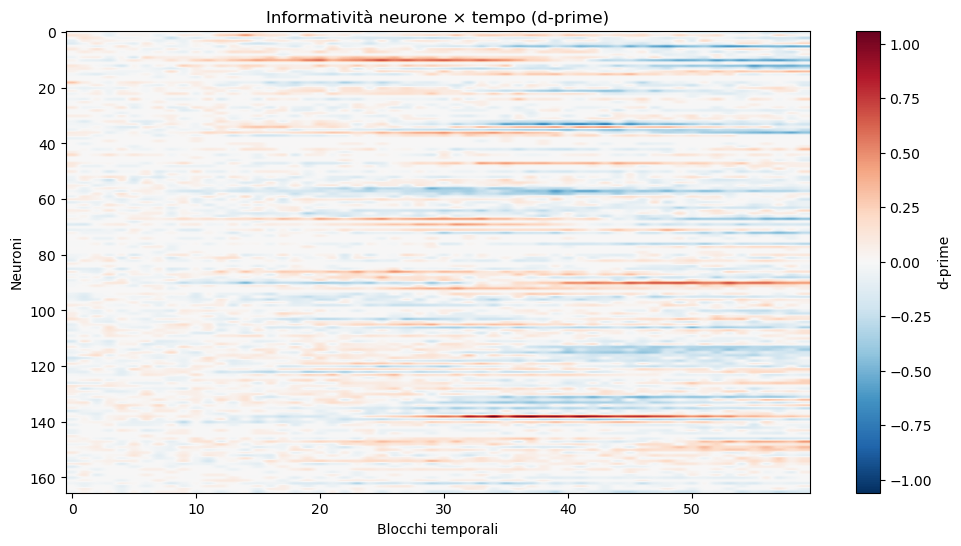

In [7]:
plt.figure(figsize=(12, 6))
plt.imshow(dpr, aspect='auto', cmap='RdBu_r', vmin=-np.max(np.abs(dpr)), vmax=np.max(np.abs(dpr)))
plt.colorbar(label="d-prime")
plt.xlabel("Blocchi temporali")
plt.ylabel("Neuroni")
plt.title("Informatività neurone × tempo (d-prime)")
plt.show()

We have a pretty informative looking raster plot fellas, now the question is if we can build a Classifier on this d-prime metric

In [8]:
def correlation_classifier(train_data, train_labels, test_data):
    n_trials, n_neurons, n_bins = train_data.shape
    proto1= train_data[train_labels==1].mean(axis=0)
    proto2= train_data[train_labels==2].mean(axis=0)
    weights = d_prime_classification(train_data, train_labels, bin_size=1)
    weights /= weights.sum()
    
    # Initialize predictions as a list - remove the reshape attempt
    predictions = []
    
    for trial in test_data:
        corr1 = np.corrcoef((trial*weights[:,None]).ravel(),
                            (proto1*weights[:,None]).ravel())[0,1]
        corr2 = np.corrcoef((trial*weights[:,None]).ravel(),
                            (proto2*weights[:,None]).ravel())[0,1]
        predictions.append(1 if corr1 > corr2 else 2)
    
    # Return predictions as a numpy array
    return np.array(predictions), proto1, proto2, weights

In [9]:
X=z_matrix_GO
y=BHV_GO['TargetPos']
X_train,X_test,y_train,y_test=train_test_split(X,y,
                                               test_size=0.2,
                                               random_state=42,
                                               stratify=y)
print(np.unique(y, return_counts=True))

(array([1., 2.]), array([399, 396], dtype=int64))


In [10]:
print(y_test.shape)
print(y_train.shape)

(159,)
(636,)


Accuracy 0.9308176100628931


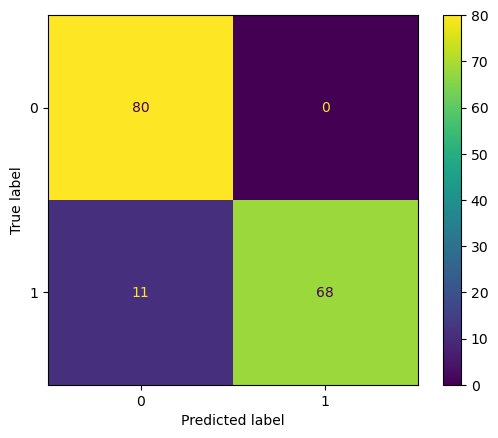

In [11]:
y_pred,proto1,proto2,weights=correlation_classifier(X_train, y_train, X_test)
print("Accuracy", accuracy_score(y_test, y_pred))
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

When compared to previously built correlation classifiers based on the Pearson coefficient alone the addition of the d-prime as a weight is able to significantly improve accuracy.  

In [12]:
print(proto1.shape)
print(proto2.shape)

(166, 60)
(166, 60)


Let's visualize the stereotypical example of a D1 vs D2 neural activity across the most informative time window concerning movement direction. Based on the basal ganglia model behind cortical activity it is reasonable to expect the two templates to be fairly complementary to each other as some neurons should turn off where an opposite popolation (reasonibly distinguished from the population responsible for movement in the opposite direction), so it can be interesting to see how the two templates stack up to each other. 

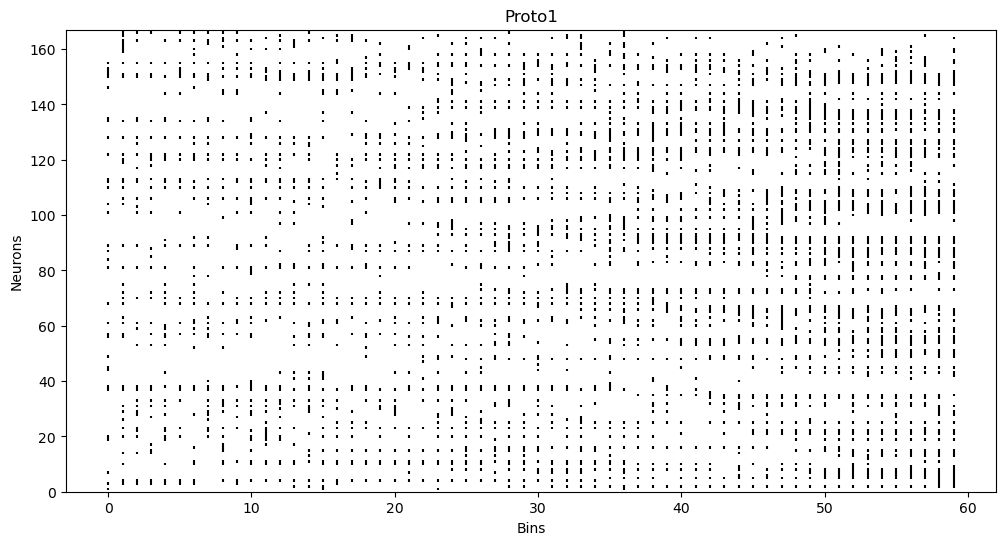

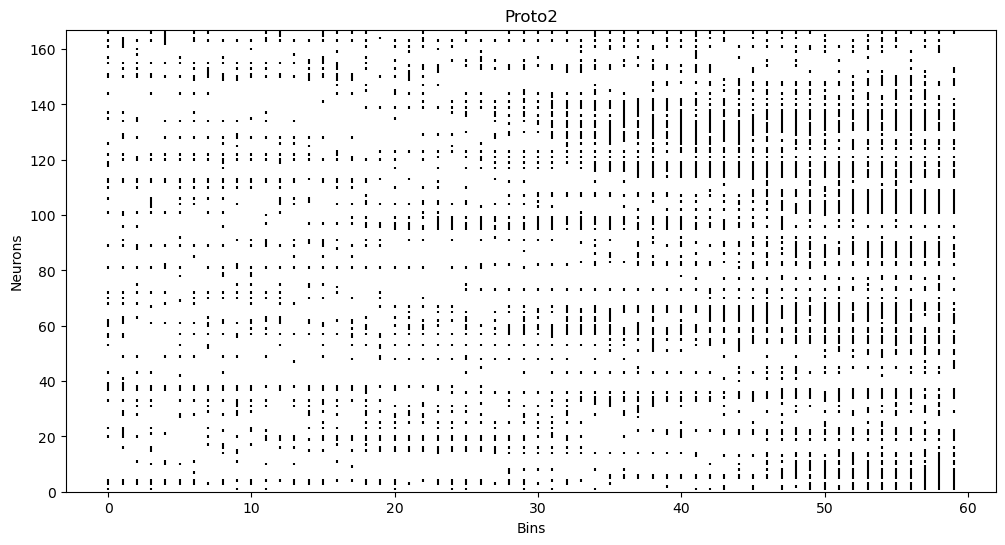

In [21]:
def plot_raster(data, title="Raster plot"):
    n_neurons, n_bins=data.shape
    plt.figure(figsize=(12,6))
    for neuron in range(n_neurons):
        spikes=np.where(data[neuron]>0)[0]
        plt.vlines(spikes, neuron+0.5,neuron+1.5, color='black')
    plt.xlabel("Bins")
    plt.ylabel("Neurons")
    plt.title(title)
    plt.ylim(0,n_neurons+1)
    plt.show()
plot_raster(proto1, "Proto1")
plot_raster(proto2,"Proto2")

In [25]:
mean1=proto1.mean(axis=0)
mean2=proto2.mean(axis=0)
temporal_correlation=np.corrcoef(mean1,mean2)[0,1]
print("Pearson coefficient", temporal_correlation)

Pearson coefficient 0.964607271973249


The two templates appear to be fairly similar but to have some meaningful differences, which we would expect given the topical organization of the cerebral cortex as the two actions are fairlty similar and share similar muscle recruiment both quantitatively and qualitatively.

In [34]:
activity = loadmat(r"C:\Users\PC_Simeone\Downloads\Labels.mat")
print(activity)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Mar 22 18:16:27 2024', '__version__': '1.0', '__globals__': [], 'Labels': array([[array(['narrow'], dtype='<U6'), array(['broad'], dtype='<U5'),
        array(['narrow'], dtype='<U6'), array(['narrow'], dtype='<U6'),
        array(['broad'], dtype='<U5'), array(['narrow'], dtype='<U6'),
        array(['narrow'], dtype='<U6'), array(['broad'], dtype='<U5'),
        array(['broad'], dtype='<U5'), array(['broad'], dtype='<U5'),
        array(['narrow'], dtype='<U6'), array(['narrow'], dtype='<U6'),
        array(['narrow'], dtype='<U6'), array(['broad'], dtype='<U5'),
        array(['fuzzy'], dtype='<U5'), array(['broad'], dtype='<U5'),
        array(['broad'], dtype='<U5'), array(['broad'], dtype='<U5'),
        array(['broad'], dtype='<U5'), array(['broad'], dtype='<U5'),
        array(['broad'], dtype='<U5'), array(['broad'], dtype='<U5'),
        array(['broad'], dtype='<U5'), array(['broad'], dtype='<U5'),
     

In [36]:
assert activity.shape[0]==n_neurons
df_proto1=pd.Dataframe(proto1)
df_proto1["Activity"]=activity 
df_proto2=pd.Dataframe(proto2)
df_proto2["Activity"]=activity

AttributeError: 'dict' object has no attribute 'shape'